In [1]:
import numpy as np 
import pandas as pd

In [2]:
import cv2 
import os 
import glob 
import matplotlib.pyplot as plt 
import re
import numpy as np 
import pandas as pd
%matplotlib inline 

(416, 84600)


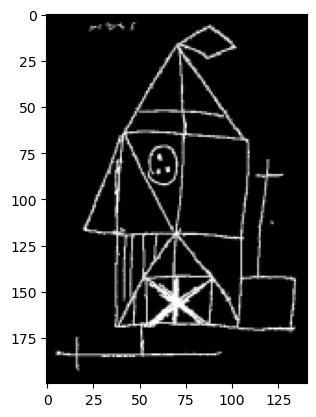

In [3]:
from PIL import Image, ImageFilter

img_dir = "C:/Users/kirti/Documents/FAU Exercises and Lectures/semester 2/Project/ROCFT_data/ROCFT_data/build/first-set/drawings" # Enter Directory of all images
img_dir2 = "C:/Users/kirti/Documents/FAU Exercises and Lectures/semester 2/Project/ROCFT_data/ROCFT_data/build/second-set/drawings"
data_path1 = os.path.join(img_dir,'*_0.jpg') 
copied_images = glob.glob(data_path1) 

data_path3 = os.path.join(img_dir2,'*_0.jpg') 
copied_images2 = glob.glob(data_path3)

data_path2 = os.path.join(img_dir,'*_1.jpg') 
recalled_images = glob.glob(data_path2)

data_path4 = os.path.join(img_dir2,'*_1.jpg') 
recalled_images2 = glob.glob(data_path4)

all_copied_images = copied_images + copied_images2
all_recalled_images = recalled_images + recalled_images2

images = [] 
labels = []

def get_numeric_part(filename):
    label = filename.split('\\')[-1]   
    substring = label.split('_')[0]
    parts = re.split(r'[\s\W]+', substring)


    for part in parts:
        if part.isdigit():
            return int(part)
    return -1 

def get_numeric_part_1(filename):
    label = filename.split('\\')[-1]   
    substring = label.split('_')[1]
    parts = re.split(r'[\s\W]+', substring)

    for part in parts:
        if part.isdigit():
            return int(part)
    return -1

copied_sorted_files = sorted(all_copied_images, key=get_numeric_part)
recalled_sorted_files = sorted(all_recalled_images, key=get_numeric_part)

all_sorted_files = copied_sorted_files + recalled_sorted_files


for f1 in all_sorted_files: 

    img = cv2.imread(f1) 
    scale_percent = 40
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
  
    # resize image
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    plt.imshow(img)
    img = img.flatten()
    images.append(img) 

image_data = np.array(images)
print(image_data.shape)


In [4]:
# binarize
from gtda.images import Binarizer

# image_datas = image_data.reshape((-1, 200, 141, 3))
image_datas = image_data.reshape((-1, 200, 423))

In [5]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude
from gtda.homology import CubicalPersistence
from gtda.diagrams import Scaler

steps = [
    ("binarizer", Binarizer(threshold=0.4)),
#     ("filtration", RadialFiltration(center=np.array([20, 6]))),
    ("diagram", CubicalPersistence()),
    ("rescaling", Scaler()),
    ("amplitude", Amplitude(metric="heat", metric_params={'sigma':0.15, 'n_bins':60}))
]

heat_pipeline = Pipeline(steps)

In [6]:
im_pipeline = heat_pipeline.fit_transform(image_datas)
im_pipeline

array([[ 22.49163708,  38.98550427],
       [ 56.97881394,   7.49721236],
       [ 50.98104405,  19.49275214],
       [ 49.48160158,  37.4860618 ],
       [  8.99665483, 206.92306114],
       [  5.99776989, 247.40800788],
       [ 32.98773438,  26.9899645 ],
       [ 10.4960973 , 190.42919395],
       [ 20.99219461,  82.46933596],
       [ 16.49386719, 139.4481499 ],
       [ 22.49163708,  83.96877843],
       [ 22.49163708, 275.89741485],
       [ 11.99553978, 190.42919395],
       [  2.99888494, 308.88514924],
       [ 13.49498225, 419.84389217],
       [ 16.49386719, 169.43699934],
       [ 43.48383169, 133.45038001],
       [ 29.98884944, 232.41358316],
       [ 28.48940697, 110.95874293],
       [ 26.9899645 , 232.41358316],
       [ 25.49052202, 236.91191058],
       [ 55.47937146,  92.96543327],
       [ 17.99330966, 160.44034451],
       [ 10.4960973 , 349.37009598],
       [ 32.98773438, 179.93309664],
       [  1.49944247, 152.94313215],
       [  8.99665483, 349.37009598],
 

In [7]:
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude
from gtda.homology import CubicalPersistence
from gtda.diagrams import Scaler

# direction_list = [[1, 0], [0, 1], [-1, 0], [0, -1]]
direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]] # reduce to just 4

filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
)

diagram_steps = [
    [
        Binarizer(threshold=0.3, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
# can try correlation
metric_list = [
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)] 
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list] #turning into single vectors
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

In [8]:
from sklearn import set_config
set_config(display='diagram')  

tda_union

FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.3)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                 Persist...
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-11',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-12',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-13',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1))]))]))])

In [9]:
print(image_datas.shape)
image_datas_tda = tda_union.fit_transform(image_datas)
print(image_datas_tda.shape)

(416, 200, 423)
(416, 224)


          0         1         2         3         4         5         6    \
0    1.000000  0.182362  0.380023  0.171492  0.477054  0.158765  0.386691   
1    0.182362  1.000000  0.165695  0.649305  0.113050  0.708156  0.167179   
2    0.380023  0.165695  1.000000  0.190692  0.928425  0.179241  0.995883   
3    0.171492  0.649305  0.190692  1.000000  0.179814  0.973082  0.182177   
4    0.477054  0.113050  0.928425  0.179814  1.000000  0.157639  0.918687   
..        ...       ...       ...       ...       ...       ...       ...   
219  0.117017  0.848060  0.095055  0.522977  0.056932  0.589005  0.091026   
220  0.787153 -0.140091  0.414493 -0.029733  0.532721 -0.053463  0.409693   
221  0.117351  0.848658  0.093700  0.519610  0.055362  0.585582  0.089715   
222  0.782657 -0.141954  0.418628 -0.028108  0.537426 -0.052207  0.413432   
223  0.117016  0.848059  0.095056  0.522979  0.056933  0.589007  0.091026   

          7         8         9    ...       214       215       216  \
0  

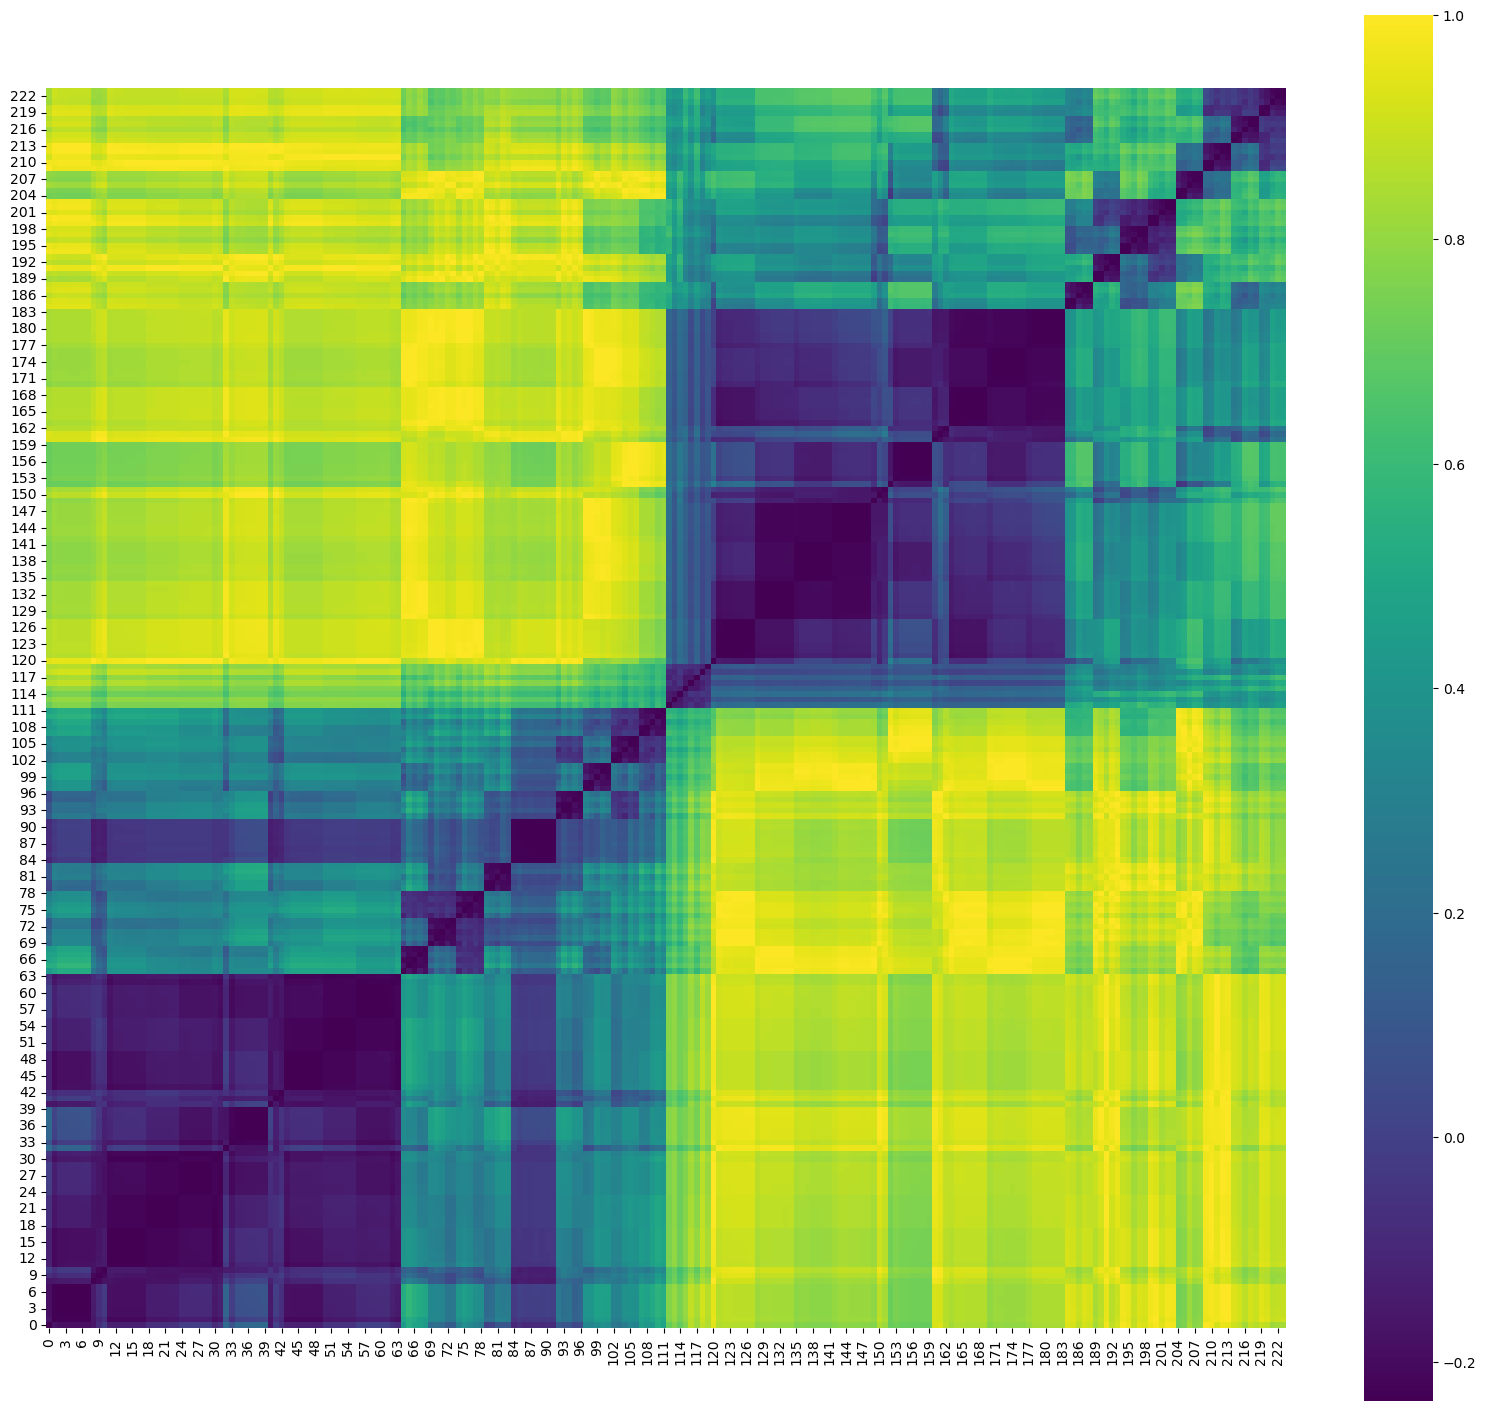

Method:	 single


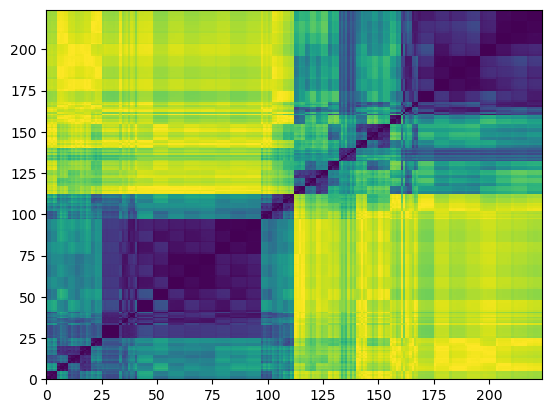

Method:	 average


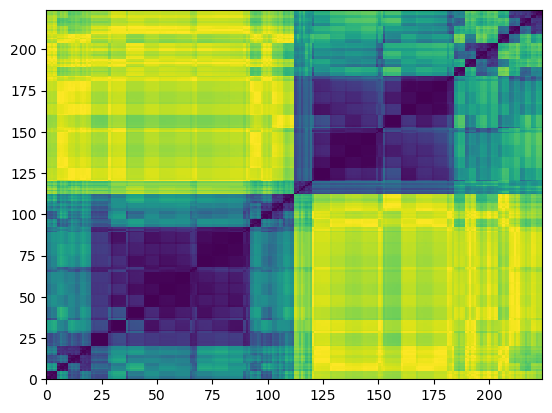

Method:	 complete


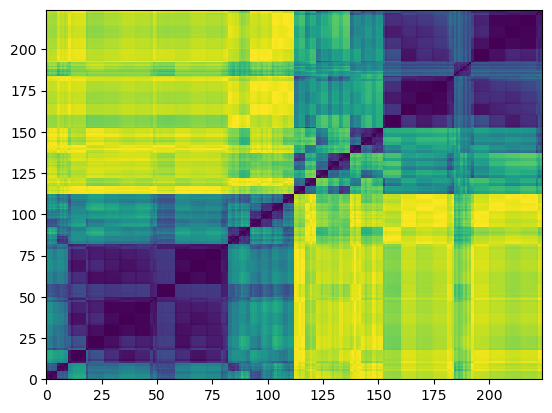

In [10]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(image_datas_tda)

corr = df.corr()
print(corr)
f, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(corr, cmap='viridis', square=True)

from fastcluster import linkage
from scipy.spatial.distance import squareform

def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z

        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))

def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)

        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]

    return seriated_dist, res_order, res_linkage


N = len(corr)
dissimilarity = 1 - abs(corr.values)
methods = ["ward","single","average","complete"]
for method in methods:
    print("Method:\t",method)

    ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(dissimilarity,method)

    plt.pcolormesh(ordered_dist_mat)
    plt.xlim([0,N])
    plt.ylim([0,N])
    plt.show()


In [11]:
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
im_pipeline_fs = df.drop(df[to_drop], axis=1).values
print("Number of features to drop: ", len(to_drop))
print("Remaining features: ", im_pipeline_fs.shape[-1])

Number of features to drop:  203
Remaining features:  21


In [12]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0.1)
im_pipeline_highvar = sel.fit_transform(image_datas_tda)
print("Number of constant features: ", image_datas_tda.shape[-1]-im_pipeline_highvar.shape[-1])
print("Remaining features: ", im_pipeline_highvar.shape[-1])

qsel = VarianceThreshold(threshold=0.1)
im_pipeline_qhighvar = qsel.fit_transform(image_datas_tda)
print("Number of quasi-constant features: ", image_datas_tda.shape[-1]-im_pipeline_qhighvar.shape[-1])
print("Remaining features: ", im_pipeline_qhighvar.shape[-1])

Number of constant features:  104
Remaining features:  120
Number of quasi-constant features:  104
Remaining features:  120


In [13]:
#loading scores from csv files
import csv
import os
import re

csv_path = 'C:/Users/kirti/Documents/FAU Exercises and Lectures/semester 2/Project/ROCFT_data/ROCFT_data/build/digitized'

csv_files = [file for file in os.listdir(csv_path) if file.endswith('.csv')]

def get_numeric_part(filename):
    parts = re.split(r'[\s\W]+', filename)
    for part in parts:
        if part.isdigit():
            return int(part)
    return -1 

sorted_files = sorted(csv_files, key=get_numeric_part)

row_index = 17  
col_index = 0  
cell_value = 0
rocft_scores = []
for csv_file in sorted_files:
    file_path = os.path.join(csv_path, csv_file)
    
    with open(file_path, 'r', newline='') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        for _ in range(row_index + 1):
            next(csv_reader)
            
        for row in csv_reader:
            cell_value = row[col_index]
            rocft_scores.append(cell_value)
            break  
            
col_index1 = 1  
cell_value1 = 0
for csv_file in sorted_files:
    file_path = os.path.join(csv_path, csv_file)
    
    with open(file_path, 'r', newline='') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        for _ in range(row_index + 1):
            next(csv_reader)
            
        for row in csv_reader:
            cell_value1 = row[col_index1]
            rocft_scores.append(cell_value1)
            break

In [57]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models

rocft_scores = [float(label) for label in rocft_scores]


X = im_pipeline_fs
y = np.array(rocft_scores)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

model = models.Sequential([
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='relu')
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# model training
history = model.fit(X_train, y_train, epochs=20, batch_size=20, validation_data=(X_test, y_test))

# model evaluation on the test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Mean Absolute Error: {test_mae}")

Epoch 1/20
17/17 [==============================] - 1s 9ms/step - loss: 414.7741 - mean_absolute_error: 17.3090 - val_loss: 165.5108 - val_mean_absolute_error: 10.5273
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 162.9521 - mean_absolute_error: 10.1702 - val_loss: 74.7854 - val_mean_absolute_error: 6.6679
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 123.8632 - mean_absolute_error: 8.4529 - val_loss: 63.7967 - val_mean_absolute_error: 6.2186
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 123.3802 - mean_absolute_error: 8.6629 - val_loss: 60.1637 - val_mean_absolute_error: 6.3719
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 118.7901 - mean_absolute_error: 8.6977 - val_loss: 55.6017 - val_mean_absolute_error: 5.8353
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 121.2063 - mean_absolute_error: 8.4755 - val_loss: 53.0763 - val_mean_absolute_error: 5.9029
Epoch 

In [58]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
y_pred = y_pred.astype(np.float64)

absolute_errors = abs(y_pred - y_test)
median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error: {median_absolute_error}")

3/3 [==============================] - 0s 4ms/step
Median Absolute Error: 4.402976036071777


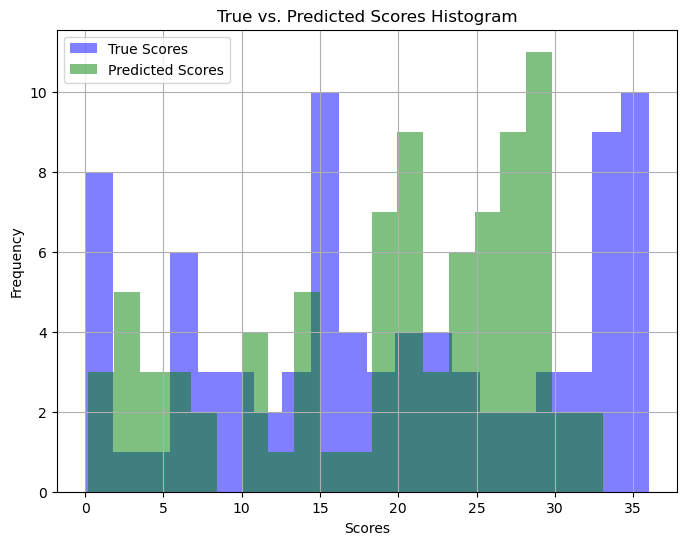

In [59]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.hist(y_test, bins=20, alpha=0.5, label='True Scores', color='blue')
plt.hist(y_pred, bins=20, alpha=0.5, label='Predicted Scores', color='green')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('True vs. Predicted Scores Histogram')
plt.legend()
plt.grid(True)

# Show the histogram
plt.show()


In [60]:
# Create a DataFrame with index, y_test, and y_pred
df = pd.DataFrame({'Index': range(len(y_test)), 'y_test': y_test, 'y_pred': y_pred})

# Display the DataFrame
print(df)

    Index  y_test     y_pred
0       0     0.0   6.469867
1       1    36.0  27.952850
2       2    36.0  28.957050
3       3    17.5  29.554457
4       4    26.0  30.289251
..    ...     ...        ...
79     79    19.0  15.756330
80     80    20.0  21.127884
81     81    15.0  20.644196
82     82    36.0  27.103615
83     83     7.5   4.975452

[84 rows x 3 columns]


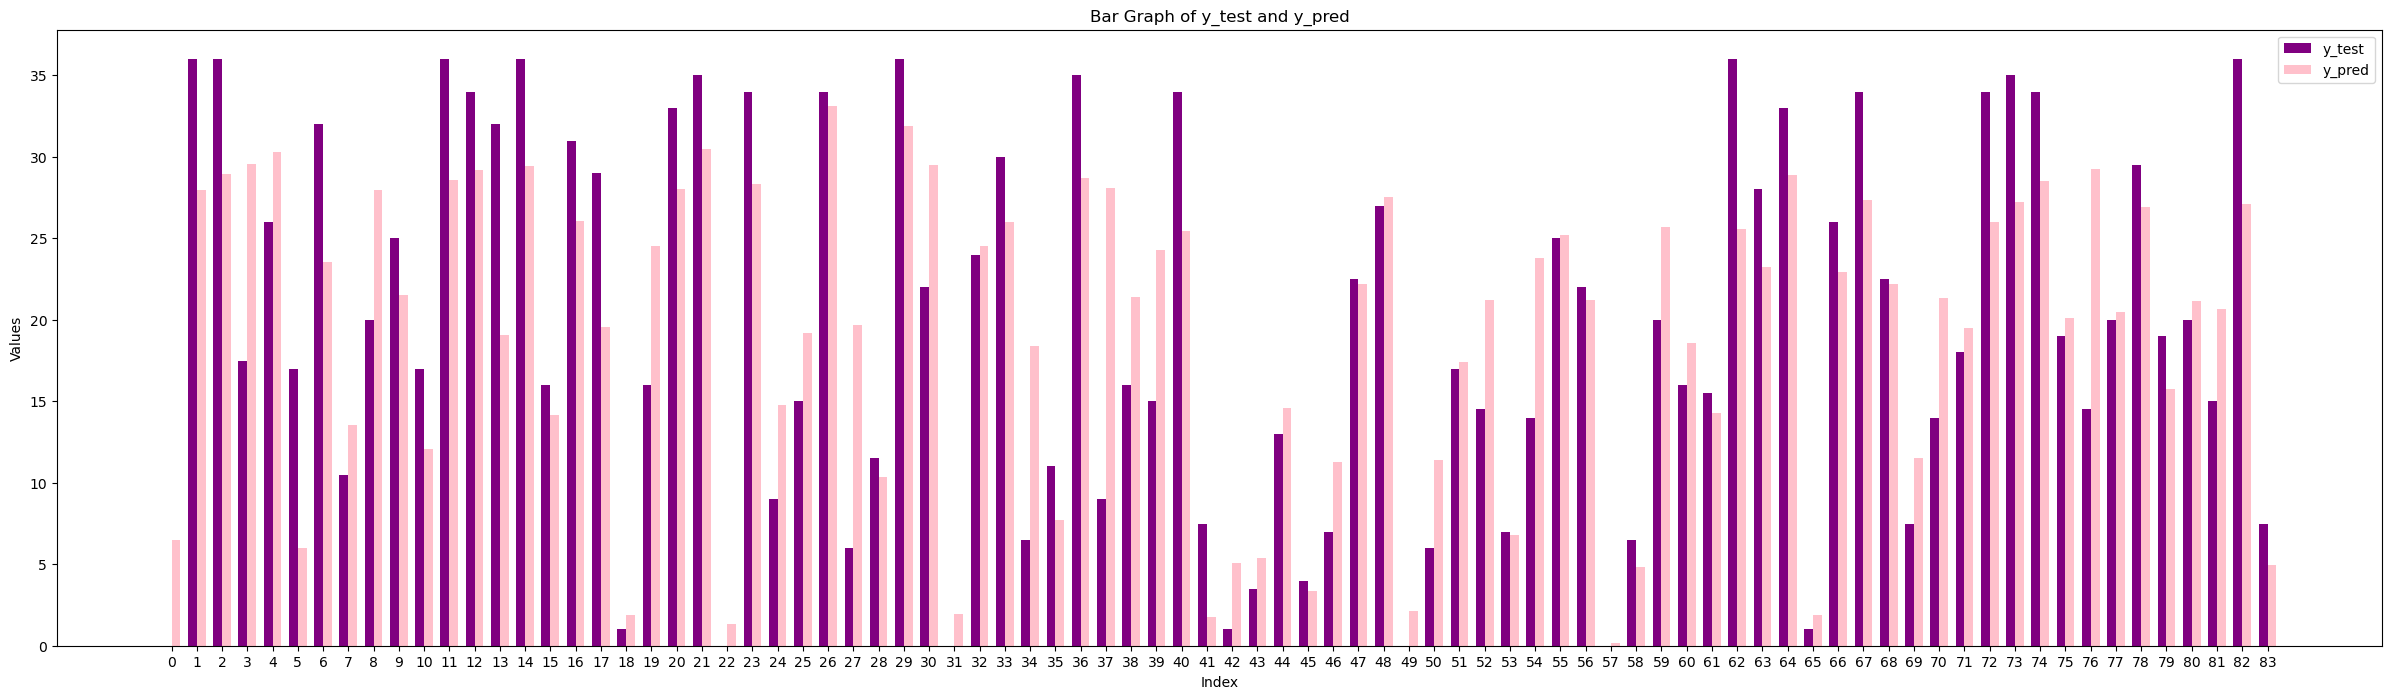

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

index_values = df['Index']
y_test_values = df['y_test']
y_pred_values = df['y_pred']

# Set the width of each bar
bar_width = 0.35

# Create a figure and axis
fig, ax = plt.subplots(figsize=(30, 8))

# Create bars for y_test
bar1 = ax.bar(index_values - bar_width/2, y_test_values, bar_width, label='y_test', color='purple')

# Create bars for y_pred
bar2 = ax.bar(index_values + bar_width/2, y_pred_values, bar_width, label='y_pred', color='pink')

# Customize the plot
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title('Bar Graph of y_test and y_pred')
ax.set_xticks(index_values)
ax.legend()

# Show the plot
plt.show()
